In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
%matplotlib inline
from jax.nn import sigmoid, log_sigmoid

In [2]:
N = 1000
K = 10

np.random.seed(2)

X = np.random.randn(N, K)
beta_true = np.random.randn(K)
gamma_true = np.random.normal()

logit_true = X @ beta_true + gamma_true

y = np.random.uniform(size=N) < sigmoid(logit_true)

In [28]:
import pystan
from stan_utils import load_stan_model_cached

# Fit this with Stan

model_data = {
    'X': X,
    'y': y.astype(int),
    'N': N,
    'K': K
}

stan_model = load_stan_model_cached('./stan_log_reg.stan')

In [29]:
fit_result = stan_model.sampling(data=model_data)

In [30]:
print(fit_result)

Inference for Stan model: anon_model_13e2503bce983084faaf24120f53644d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   -0.83  1.4e-3    0.1  -1.04   -0.9  -0.83  -0.76  -0.63   5533    1.0
beta[2]   -0.45  1.2e-3    0.1  -0.63  -0.52  -0.45  -0.38  -0.26   6685    1.0
beta[3]   -0.34  1.0e-3   0.09  -0.52   -0.4  -0.34  -0.28  -0.16   7744    1.0
beta[4]   -0.34  1.1e-3   0.09  -0.53  -0.41  -0.34  -0.28  -0.17   7131    1.0
beta[5]   -1.72  2.0e-3   0.13  -1.99  -1.81  -1.72  -1.63  -1.47   4504    1.0
beta[6]    0.57  1.2e-3    0.1   0.37    0.5   0.56   0.63   0.77   6970    1.0
beta[7]   -0.81  1.3e-3    0.1  -1.01  -0.88  -0.81  -0.74  -0.62   5624    1.0
beta[8]    0.15  8.9e-4   0.09  -0.02   0.09   0.15   0.21   0.32   9925    1.0
beta[9]   -1.42  1.9e-3   0.12  -1.66   -1.5  -1.41  -1.33  -1.19   4230    1.0
beta[10]  -

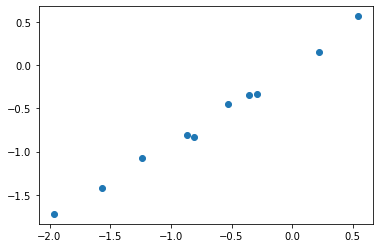

In [31]:
plt.scatter(beta_true, fit_result['beta'].mean(axis=0))

In [32]:
gamma_true

0.25193706697790286

In [33]:
from jax_advi.advi import optimize_advi_mean_field
from jax import jit
from jax.scipy.stats import norm

In [34]:
# Try ADVI
theta_shapes = {
    'beta': (K),
    'gamma': ()
}

In [35]:
def calculate_likelihood(theta, X, y):
    
    logit_prob = X @ theta['beta'] + theta['gamma']
    
    prob_pres = log_sigmoid(logit_prob)
    prob_abs = log_sigmoid(-logit_prob)
    
    return jnp.sum(y * prob_pres + (1 - y) * prob_abs)

def calculate_prior(theta):
    
    beta_prior = jnp.sum(norm.logpdf(theta['beta']))
    gamma_prior = jnp.sum(norm.logpdf(theta['gamma']))
    
    return beta_prior + gamma_prior

In [11]:
from functools import partial

In [12]:
log_lik_fun = jit(partial(calculate_likelihood, X=X, y=y))
log_prior_fun = jit(calculate_prior)

In [13]:
result = optimize_advi_mean_field(theta_shapes, log_prior_fun, log_lik_fun, n_draws=None)

In [14]:
result

{'free_means': {'beta': array([-0.82344996, -0.44693485, -0.33946258, -0.35119831, -1.70629835,
          0.55354204, -0.80549964,  0.14861987, -1.42311193, -1.06534286]),
  'gamma': array(0.30991296)},
 'free_sds': {'beta': DeviceArray([0.09989063, 0.09379449, 0.09851529, 0.09609015, 0.11003966,
               0.09300026, 0.08662668, 0.09549714, 0.09975527, 0.08704654],            dtype=float32),
  'gamma': DeviceArray(0.09323669, dtype=float32)},
 'opt_result':       fun: array(418.88650513)
  hess_inv: <22x22 LbfgsInvHessProduct with dtype=float64>
       jac: array([-0.00772798,  0.00264925,  0.00566322, -0.00923032,  0.00204819,
        -0.00964478,  0.00459319,  0.00268805, -0.00132859,  0.00446451,
         0.00776583, -0.00357068,  0.00035286, -0.00168037, -0.00022566,
        -0.00010026, -0.00145274,  0.00488627, -0.002267  ,  0.00397432,
         0.00257874, -0.00269526])
   message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      nfev: 37
       nit: 21
    status:

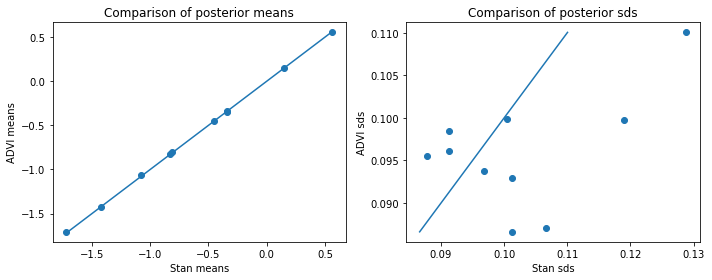

In [27]:
f, ax = plt.subplots(1, 2)

ax[0].scatter(fit_result['beta'].mean(axis=0), result['free_means']['beta'])

ax[0].plot([result['free_means']['beta'].min(), result['free_means']['beta'].max()],
           [result['free_means']['beta'].min(), result['free_means']['beta'].max()])

ax[1].scatter(fit_result['beta'].std(axis=0), result['free_sds']['beta'])
ax[1].plot([result['free_sds']['beta'].min(), result['free_sds']['beta'].max()],
              [result['free_sds']['beta'].min(), result['free_sds']['beta'].max()])

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('ADVI means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('ADVI sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('logistic_reg_comparison.png', dpi=300)